# MOSAIKS: Train and test example for kenyan land value estimation

 There are three steps: 

1) Merge labels with corresponding MOSAIKS features, based on location

2) Train the prediction model using ridge regression and k-fold cross-validation

3) Show performance on the validation set of labeled data 


### Import necessary packages

In [55]:
# Import necessary packages: These include custom MOSAIKS packages contained within the repo, as well as standard Python packages.
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from mosaiks import config as c
from mosaiks.utils.imports import *
import sys
print(c.__file__)

In [ ]:
pip install plotly

In [57]:

from scipy.stats import spearmanr
import geopandas as gpd
import random
import os
import numpy as np
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import r2_score
import plotly.express as px

### Task-specific settings for the mosaiks package

In [58]:
# Name of your task
app = "housing"
c_app = getattr(c, app)
outcome_name = c_app["variable"]

# Choose the sampling scheme for the grid (options: UAR (uniform-at-random) or POP (population-weighted))
sampling_type = c_app["sampling"]

# Choose whether to log the outcome variable or not for training and prediction
# (we log outcome variables with approximately log-normal distributions in the labeled data)
logs = c_app["logged"]

# These bounds are used to clip predictions at the observed minimum and maximum of the outcome
# variable in the labeled data
if logs == False:
    bounds = np.array([c_app["us_bounds_pred"]])
else:
    bounds = np.array([c_app["us_bounds_log_pred"]])

# Inputs needed to train model using ridge regression
solver_kwargs = {
    # set of possible hyperparameters to search over in cross-validation
    "lambdas": c_app["lambdas"],
    # do you want to return the predictions from the model?
    "return_preds": True,
    # input the bounds used to clip predictions
    "clip_bounds": bounds,
    # do you want to use an SVD solve or standard linear regression? (NB: SVD is much slower)
    "svd_solve": False,
    # do you want to allow hyperparameters to be chosen even if they lead to warnings about matrix invertibility?
    "allow_linalg_warning_instances": False,
}

# Set solver: We use ridge regression to solve the linear regression model. Other options may be explored by future users.
solver = solve.ridge_regression

# For plotting:
%matplotlib inline
sns.set(style="whitegrid")

### Donot Run: Train model for 15 cities

This would crash the computer

In [ ]:

X_full = []
Y_full = []
latlons_train_full = []
for city in c.cities:
# Load random features
    X, latlons = io.get_X_latlon(c,city, 100)
    (
    X_train,
    _,
    Y_train,
    _,
    latlons_train,
    _,
    ) = parse.merge_dropna_transform_split_train_test(c,city, app, X, latlons)
    print(X.shape)
    X_full.append(X_train)
    Y_full.append(Y_train)
    latlons_train_full.append(latlons_train)

In [11]:

filepath = 'C:\\Users\\DELL\\Documents\\Github\\kanyan\\data\\int\\test-chunck'

In [12]:
chunk_size = 10000  # Specify the size of each chunk
num_chunks = len(X_full) // chunk_size

for i in range(num_chunks):
    start = i * chunk_size
    end = start + chunk_size
    chunk = X_full[start:end]
    filename = output_file
    output_file = os.path.join(filepath, filename)
    np.save(output_file, chunk)


## Run random test

#### 3 cities for training and 1 city for testing

In [ ]:

cities = ['Eldoret', 'Embu', 'Garissa', 'Kakamega', 'Kericho', 'Kisumu', 'Kitui', 'Machakos', 'Malindi', 'Mombasa', 'Nairobi', 'Naivasha', 'Nakuru', 'Nyeri', 'Thika']

test_city = random.choice(cities)
train_cities = random.sample([city for city in cities if city != test_city], 3)

# Perform your desired operations or analysis on train and test samples
X_random = []
Y_random = []
latlons_train_random = []
for city in train_cities:
# Load random features
    X, latlons = io.get_X_latlon(c,city, 100)
    (
    X_train,
    _,
    Y_train,
    _,
    latlons_train,
    _,
    ) = parse.merge_dropna_transform_split_train_test(c,city, app, X, latlons)
    print(X_train.shape)
    X_random.append(X_train)
    Y_random.append(Y_train)
    latlons_train_random.append(latlons_train)

#Load test samples
X, latlons = io.get_X_latlon(c,test_city, 100)
(
X_test,
_,
Y_test,
_,
latlons_test,
_,
) = parse.merge_dropna_transform_split_train_test(c,test_city, app, X, latlons)

print(X_test.shape)

X_random= np.concatenate(X_random)
Y_random=np.concatenate(Y_random)
print("Train X shape:",X_random.shape)
latlons_train_random = np.concatenate(latlons_train_random)

# Print or save the train and test cities
print("Train cities:", train_cities)
print("Test cities:", test_city)

In [34]:
X_random.shape

(4173, 430336)

In [35]:
points = pd.DataFrame(latlons_train_random,columns=['lat','lon'])
gdf_train = gpd.GeoDataFrame(points, geometry=gpd.points_from_xy(points['lat'], points['lon']))
gdf_train['houseprice'] =  Y_random

gdf_train

,lat,lon,geometry,houseprice
0,0.302892,34.776048,POINT (0.30289 34.77605),2.510008
1,0.239256,34.721502,POINT (0.23926 34.72150),0.000000
2,0.236529,34.718775,POINT (0.23653 34.71877),0.000000
3,0.336528,34.800593,POINT (0.33653 34.80059),0.000000
4,0.262893,34.781502,POINT (0.26289 34.78150),0.000000
...,...,...,...,...
4168,-4.124005,39.664872,POINT (-4.12401 39.66487),0.000000
4169,-3.942637,39.765781,POINT (-3.94264 39.76578),0.000000
4170,-4.112218,39.615781,POINT (-4.11222 39.61578),0.000000
4171,-3.956241,39.593963,POINT (-3.95624 39.59396),0.000000


#### Plot the training data and the distribution:

In [36]:


fig = px.scatter_mapbox(gdf_train, lat="lat", lon="lon", hover_name="houseprice", hover_data=["houseprice"],color ="houseprice",
                        color_discrete_sequence=["fuchsia"], zoom=3, height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

#### Plot the testing data and the distribution:

In [68]:
#Load test samples
X, latlons = io.get_X_latlon(c,test_city, 100)
(
X_test,
Y_test,
latlons_test,
) = parse.merge_dropna_transform_split_train_test(c,test_city, app, X, latlons)

print(X_test.shape)


# Print or save the train and test cities
print("Train cities:", train_cities)
print("Test cities:", test_city)

Loading labels...
Merging labels and features...
(1605, 430336)
Train cities: ['Kakamega', 'Malindi', 'Mombasa']
Test cities: Thika


In [70]:

points = pd.DataFrame(latlons_test,columns=['lat','lon'])
gdf_test = gpd.GeoDataFrame(points, geometry=gpd.points_from_xy(points['lat'], points['lon']))
gdf_test['houseprice'] =  Y_test

gdf_test

,lat,lon,geometry,houseprice
0,-1.010264,37.105278,POINT (-1.01026 37.10528),0.0
1,-1.010264,37.018005,POINT (-1.01026 37.01801),0.0
2,-1.010264,37.116187,POINT (-1.01026 37.11619),0.0
3,-1.010264,37.127096,POINT (-1.01026 37.12710),0.0
4,-1.010264,37.138005,POINT (-1.01026 37.13800),0.0
...,...,...,...,...
1600,-1.091159,37.045278,POINT (-1.09116 37.04528),0.0
1601,-1.091159,37.056187,POINT (-1.09116 37.05619),0.0
1602,-1.091159,37.067096,POINT (-1.09116 37.06710),0.0
1603,-1.091159,37.078005,POINT (-1.09116 37.07800),0.0


<Axes: ylabel='Frequency'>

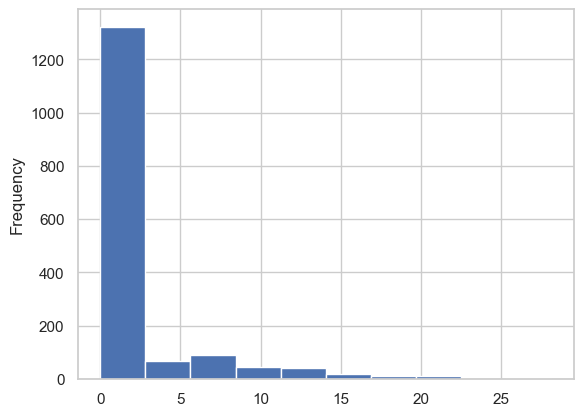

In [72]:
gdf_test['houseprice'].plot.hist()

In [71]:


fig = px.scatter_mapbox(gdf_test, lat="lat", lon="lon", hover_name="houseprice", hover_data=["houseprice"],color="houseprice",
                        color_discrete_sequence=["fuchsia"], zoom=3, height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

#### Train Ridge model

In [73]:
import numpy as np

# Create a mask for infinite values
inf_mask_y_train = (Y_random ==0)| (Y_random ==-999)

# Filter out the rows with infinite values
X_train_clean = X_random[~inf_mask_y_train]
Y_train_clean = Y_random[~inf_mask_y_train]


In [74]:
X_train_clean.shape

(748, 430336)

In [75]:
Y_train_clean.shape

(748,)

In [79]:
x_train, x_test, y_train, y_test = train_test_split(
    X_train_clean, Y_train_clean, test_size=0.2, random_state=0
)

# Create a mask for infinite values
inf_mask_y_test = (Y_test ==0)| (Y_test ==-999)

# Filter out the rows with infinite values
X_test_clean = X_test[~inf_mask_y_test]
Y_test_clean = Y_test[~inf_mask_y_test]


In [83]:

# Define the range of alpha values using np.logspace
alpha_values = np.logspace(-3, 3, 9)

best_alpha = None
best_avg_r2 = -np.inf
best_model = None
best_predictions = None

# Perform k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for alpha in alpha_values:
    r2_scores = []
    predictions = []
    for train_indxs, val_indxs in kf.split(X_train_clean):
        # Split the data into training and validation sets for the current fold
        X_train_fold, X_val_fold = X_train_clean[train_indxs], X_train_clean[val_indxs]
        y_train_fold, y_val_fold = Y_train_clean[train_indxs], Y_train_clean[val_indxs]

        # Create and fit the Ridge regression model with the current alpha
        ridge_model = Ridge(alpha=alpha)
        ridge_model.fit(X_train_fold, y_train_fold)

        # Predict on the validation set
        y_pred = ridge_model.predict(X_val_fold)

        # Calculate the R-squared score for the current fold
        r2 = r2_score(y_val_fold, y_pred)
        r2_scores.append(r2)

    # Calculate the average R-squared score across all folds for the current alpha
    avg_r2 = np.mean(r2_scores)
    predictions.append(y_pred)

    # Check if the current alpha gives a better average performance
    if avg_r2 > best_avg_r2:
        best_avg_r2 = avg_r2
        best_alpha = alpha
        best_model = ridge_model
        best_predictions = np.concatenate(predictions)

# Print the best alpha and corresponding average R-squared score
print("Best Alpha:", best_alpha)
print("Best Average R-squared:", best_avg_r2)


Best Alpha: 0.03162277660168379
Best Average R-squared: 0.613675522830085


##### Show performance in test set

In [89]:
from sklearn.metrics import mean_squared_error

# Calculate MSE for the best model
best_model_predictions = best_model.predict(x_test)
mse = mean_squared_error(y_test, best_model_predictions)
r2 = r2_score(y_test, best_model_predictions)

# Print the MSE
print("Mean Squared Error:", mse)
print("R2", r2)

Mean Squared Error: 6.012685979536413
R2 0.8125687625834093


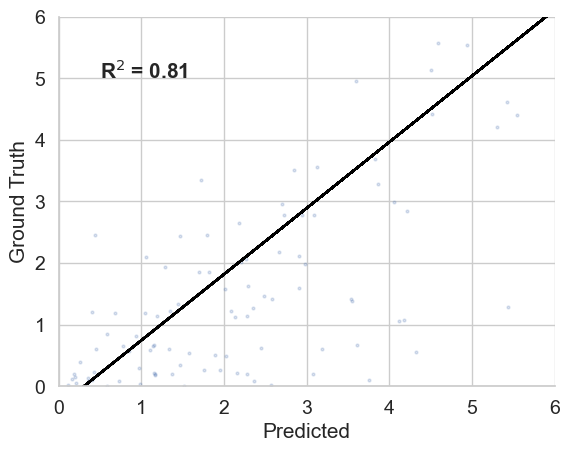

In [92]:
plt.figure()
plt.scatter(best_model_predictions,y_test, alpha=0.2, s=4)
plt.xlabel("Predicted", fontsize=15)
plt.ylabel("Ground Truth", fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlim([0, 6])
plt.ylim([0, 6])

plt.text(
    0.5,
    5,
    s="R$^2$ = %0.2f" % (r2_score(y_test, best_model_predictions)),
    fontsize=15,
    fontweight="bold",
)
m, b = np.polyfit(best_model_predictions, y_test, 1)
plt.plot(best_model_predictions, m * best_model_predictions + b, color="black")
plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)

plt.show()
plt.close()

#### Performance in a new city

In [93]:


# Calculate MSE for the best model
best_model_predictions = best_model.predict(X_test_clean)
mse = mean_squared_error(Y_test_clean, best_model_predictions)
r2 = r2_score(Y_test_clean, best_model_predictions)

# Print the MSE
print("Mean Squared Error:", mse)
print("R2", r2)

Mean Squared Error: 452.4191588666692
R2 -15.579098475127438


### Run test: 1 cities for training and 1 city for testing

In [124]:

# Create a mask for infinite values
inf_mask_y_train = (Y_full[0] ==0)| (Y_full[0] ==-999)

# Filter out the rows with infinite values
X_train_clean = X_full[0][~inf_mask_y_train]
Y_train_clean = Y_full[0][~inf_mask_y_train]

In [125]:
print("X_train_clean:",X_train_clean.shape)

X_train_clean: (475, 430336)


In [126]:
print("X_train_clean:",X_train_clean.shape)

X_train_clean: (475, 430336)


In [127]:

# Define the range of alpha values using np.logspace
alpha_values = np.logspace(-3, 3, 9)

best_alpha = None
best_avg_r2 = -np.inf
best_model = None
best_predictions = None

# Perform k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for alpha in alpha_values:
    r2_scores = []
    predictions = []
    for train_indxs, val_indxs in kf.split(X_train_clean):
        # Split the data into training and validation sets for the current fold
        X_train_fold, X_val_fold = X_train_clean[train_indxs], X_train_clean[val_indxs]
        y_train_fold, y_val_fold = Y_train_clean[train_indxs], Y_train_clean[val_indxs]

        # Create and fit the Ridge regression model with the current alpha
        ridge_model = Ridge(alpha=alpha)
        ridge_model.fit(X_train_fold, y_train_fold)

        # Predict on the validation set
        y_pred = ridge_model.predict(X_val_fold)

        # Calculate the R-squared score for the current fold
        r2 = r2_score(y_val_fold, y_pred)
        r2_scores.append(r2)

    # Calculate the average R-squared score across all folds for the current alpha
    avg_r2 = np.mean(r2_scores)
    predictions.append(y_pred)

    # Check if the current alpha gives a better average performance
    if avg_r2 > best_avg_r2:
        best_avg_r2 = avg_r2
        best_alpha = alpha
        best_model = ridge_model
        best_predictions = np.concatenate(predictions)

# Print the best alpha and corresponding average R-squared score
print("Best Alpha:", best_alpha)
print("Best Average R-squared:", best_avg_r2)


Best Alpha: 0.1778279410038923
Best Average R-squared: 0.5738272370247495


In [131]:


# Calculate MSE for the best model
best_model_predictions = best_model.predict(X_full[1])
mse = mean_squared_error(Y_full[1], best_model_predictions)
r2 = r2_score(Y_full[1],best_model_predictions)

# Print the MSE
print("Mean Squared Error:", mse)
print("R2", r2)

Mean Squared Error: 185.20851062652082
R2 -13.298926888930396
